In [8]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Get and process files

In [9]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
import re
from typing import Any, Dict, List, Tuple, Optional, Union


# ----------------------------
# 1) File locator (decoupled)
# ----------------------------

def _format_density(density: Union[int, float, str]) -> str:
    """
    Convert density to the exact string used in folder/file names.
    Examples:
      1    -> "1"
      0.9  -> "0.9"
      0.95 -> "0.95"
      "4"  -> "4"
    """
    if isinstance(density, str):
        s = density.strip()
        # Normalize "1.0" -> "1" etc.
        try:
            f = float(s)
            if f.is_integer():
                return str(int(f))
            return s.rstrip("0").rstrip(".") if "." in s else s
        except ValueError:
            return s

    if isinstance(density, (int, float)):
        f = float(density)
        if f.is_integer():
            return str(int(f))
        # keep minimal representation (0.90 -> 0.9)
        s = repr(f)
        return s.rstrip("0").rstrip(".")
    return str(density)


def find_dat_file(
    base_dir: Union[str, Path],
    density: Union[int, float, str],
    p: int,
    h: int,
    test: Optional[int] = None,
    *,
    top_folders: Tuple[str, str] = ("Data", "Data with maintenance constraints"),
    folder_prefix: str = "d=",
    file_prefix: str = "DataCplex_",
) -> Path:
    """
    Search for the .dat matching density/p/h/(optional)test under:
      base_dir/Data/d=<density>/
      base_dir/Data with maintenance constraints/d=<density>/
    Returns the Path if uniquely found, otherwise raises an error.
    """
    base_dir = Path(base_dir)
    d_str = _format_density(density)

    candidates: List[Path] = []

    # Search both top folders (works even if one doesn't exist)
    for top in top_folders:
        d_folder = base_dir / top / f"{folder_prefix}{d_str}"
        if not d_folder.exists():
            continue

        if test is None:
            pattern = f"{file_prefix}density={d_str}_p={p}_h={h}_test_*.dat"
        else:
            pattern = f"{file_prefix}density={d_str}_p={p}_h={h}_test_{test}.dat"

        candidates.extend(sorted(d_folder.glob(pattern)))

    if not candidates:
        raise FileNotFoundError(
            f"No .dat file found for density={d_str}, p={p}, h={h}, test={test} under {base_dir}"
        )

    # If test=None we might match multiple; require uniqueness to be safe
    if len(candidates) > 1:
        msg = "\n".join(str(c) for c in candidates[:30])
        more = "" if len(candidates) <= 30 else f"\n... and {len(candidates)-30} more"
        raise FileExistsError(
            f"Multiple matching .dat files found for density={d_str}, p={p}, h={h}, test={test}:\n{msg}{more}\n"
            f"Pass test=<n> to select a unique file."
        )

    return candidates[0]


# ----------------------------
# 2) Parser (decoupled)
# ----------------------------

_DECL_RE = re.compile(r"(?ms)^\s*(\w+)\s*=\s*(.*?)\s*;\s*$")

def _parse_atom(token: str) -> Union[int, float, str]:
    token = token.strip()
    if token == "":
        return token

    # Try int then float
    try:
        if re.fullmatch(r"[+-]?\d+", token):
            return int(token)
        if re.fullmatch(r"[+-]?\d*\.\d+(?:[eE][+-]?\d+)?", token) or re.fullmatch(r"[+-]?\d+(?:[eE][+-]?\d+)", token):
            return float(token)
    except ValueError:
        pass

    # Otherwise string (e.g., airport codes A,B,C)
    return token


def _parse_set(value: str) -> List[Union[int, float, str]]:
    # value like "{A,B,C,}" or "{0,1,2,}"
    inner = value.strip()[1:-1].strip()
    if inner == "":
        return []
    parts = [p.strip() for p in inner.split(",")]
    parts = [p for p in parts if p != ""]
    return [_parse_atom(p) for p in parts]


def _parse_tuples_from_angle_brackets(value: str) -> List[Tuple[Union[int, float, str], ...]]:
    # Extract all <...> blocks, split by commas inside
    tuples: List[Tuple[Union[int, float, str], ...]] = []
    for body in re.findall(r"<([^<>]*)>", value, flags=re.S):
        fields = [f.strip() for f in body.split(",")]
        fields = [f for f in fields if f != ""]
        tuples.append(tuple(_parse_atom(f) for f in fields))
    return tuples


def _parse_matrix(value: str) -> List[List[Union[int, float]]]:
    """
    Parses something like:
      Cost =[
        [6804.0,6870.0,...,]
        [4536.0,4580.0,...,]
      ];
    Note: rows are NOT comma-separated in your file, so we scan bracket depth.
    """
    s = value.strip()
    if not (s.startswith("[") and s.endswith("]")):
        raise ValueError("Matrix must start with '[' and end with ']'")

    content = s[1:-1].strip()

    rows: List[str] = []
    i = 0
    n = len(content)
    while i < n:
        # Find next row '['
        while i < n and content[i].isspace():
            i += 1
        if i >= n:
            break
        if content[i] != "[":
            # skip unexpected chars
            i += 1
            continue

        # parse one row [...]
        depth = 0
        start = i
        while i < n:
            ch = content[i]
            if ch == "[":
                depth += 1
            elif ch == "]":
                depth -= 1
                if depth == 0:
                    end = i
                    rows.append(content[start + 1 : end])  # inside [...]
                    i += 1
                    break
            i += 1

    matrix: List[List[Union[int, float]]] = []
    for row in rows:
        nums = [x.strip() for x in row.replace("\n", " ").split(",")]
        nums = [x for x in nums if x != ""]
        parsed_row: List[Union[int, float]] = []
        for x in nums:
            atom = _parse_atom(x)
            if isinstance(atom, str):
                raise ValueError(f"Non-numeric value in matrix: {atom!r}")
            parsed_row.append(atom)
        matrix.append(parsed_row)

    return matrix


def parse_dat_file(dat_path: Union[str, Path]) -> Dict[str, Any]:
    """
    Parses an OPL/CPLEX-like .dat into a dict:
      - Sets {...} -> Python list
      - Scalars -> int/float/str
      - Tuple lists <...> -> list[tuple]
      - Matrices [...] with row brackets -> list[list[float/int]]
    """
    dat_path = Path(dat_path)
    text = dat_path.read_text(encoding="utf-8", errors="replace")

    out: Dict[str, Any] = {}

    # Split by semicolons safely by matching "name = ... ;" blocks (multiline)
    for m in _DECL_RE.finditer(text):
        name = m.group(1)
        raw = m.group(2).strip()

        if raw.startswith("{") and raw.endswith("}"):
            # could be a set, or a tuple-set like Flight = { <...> <...> }
            if "<" in raw and ">" in raw:
                out[name] = _parse_tuples_from_angle_brackets(raw)
            else:
                out[name] = _parse_set(raw)

        elif raw.startswith("[") and raw.endswith("]"):
            # could be matrix, or list of tuples inside brackets
            if "<" in raw and ">" in raw:
                out[name] = _parse_tuples_from_angle_brackets(raw)
            else:
                out[name] = _parse_matrix(raw)

        else:
            # scalar
            out[name] = _parse_atom(raw)

    return out



In [13]:
base = Path.cwd()  # or Path(__file__).resolve().parent

# Find file by params:
dat_file = find_dat_file(base, density=0.9, p=10, h=7, test=0)

data = parse_dat_file(dat_file)

print("Keys:", data.keys())
print("Nbflight:", data["Nbflight"])
print("First Flight tuple:", data["Flight"][0])
print("Cost shape:", len(data["Cost"]), "x", len(data["Cost"][0]) if data["Cost"] else 0)
print("First Aircraft tuple:", data["Aircraft"][0])

Airports   = data["Airports"]
Nbflight   = data["Nbflight"]
Aircrafts  = data["Aircrafts"]
Flight     = data["Flight"]
Cost       = data["Cost"]
Aircraft   = data["Aircraft"]

Keys: dict_keys(['Airports', 'Nbflight', 'Aircrafts', 'Flight', 'Cost', 'Aircraft'])
Nbflight: 167
First Flight tuple: (1, 'MAD', 'HAM', 6360.0, 6615.0)
Cost shape: 167 x 10
First Aircraft tuple: (0, 'HAM')


# Modeling

## Compatibility Matrix

In [54]:
# Create matrix A_ij with possible flight combinations
# A[i][j] will check if the flight j can happen after flight i
A = []
for flight in Flight:
    row = []
    for flight_compare in Flight:
        # check if 'flight_compare' can happen after 'flight'
        # this is possible if the departure time of the second flight is greater than the arrival time of the first flight
        # and if the departure airport of the second flight is equal to the arrival airport of the first flight
        if flight_compare[3] > flight[4] and flight_compare[1] == flight[2]:
            row.append(1)
        else:
            row.append(0)
    # Add the row to the matrix
    A.append(row)

## Optimizing

In [67]:
from gurobipy import Model, GRB, quicksum

turn_time = 0 

m = Model("tail_assignment_xij")

# Variables
x = m.addVars(range(Nbflight), range(len(Aircrafts)), vtype=GRB.BINARY, name="x")

# Objective function
m.setObjective(
    quicksum(Cost[i][j] * x[i, j] for i in range(Nbflight) for j in range(len(Aircrafts))),
    GRB.MINIMIZE
)

# each flight assigned to exactly one aircraft
m.addConstrs(
    (quicksum(x[i, j] for j in range(len(Aircrafts))) == 1 for i in range(Nbflight)),
    name="assign"
)

# --- overlap constraints: if flights i and k overlap in time, they can't share the same aircraft ---
# Flight tuple: (id, origin, dest, dep, arr)  -> dep at [3], arr at [4]

for i in range(Nbflight):
    dep_i = float(Flight[i][3])
    arr_i = float(Flight[i][4])

    for k in range(i + 1, Nbflight):
        dep_k = float(Flight[k][3])
        arr_k = float(Flight[k][4])

        # intervals [dep_i, arr_i] and [dep_k, arr_k] overlap if:
        # dep_i < arr_k AND dep_k < arr_i
        overlap = (dep_i < arr_k) and (dep_k < arr_i)

        if overlap:
            for a in range(len(Aircrafts)):
                m.addConstr(
                    x[i, a] + x[k, a] <= 1,
                    name=f"overlap_{i}_{k}_{a}"
                )



m.params.outputflag = 0

m.optimize()

In [68]:
from gurobipy import GRB

if m.status == GRB.OPTIMAL:
    print("Optimal objective value:", m.objVal)
else:
    print("No optimal solution, status =", m.status)

for i in range(Nbflight):
    for j in range(len(Aircrafts)):
        if x[i, j].X > 0.5:   # variable selected
            print(f"Flight {Flight[i][0]} assigned to Aircraft {Aircraft[j][0]}")





Optimal objective value: 1346703.0
Flight 1 assigned to Aircraft 8
Flight 2 assigned to Aircraft 6
Flight 3 assigned to Aircraft 8
Flight 4 assigned to Aircraft 2
Flight 5 assigned to Aircraft 9
Flight 6 assigned to Aircraft 0
Flight 7 assigned to Aircraft 5
Flight 8 assigned to Aircraft 9
Flight 9 assigned to Aircraft 5
Flight 10 assigned to Aircraft 6
Flight 11 assigned to Aircraft 7
Flight 12 assigned to Aircraft 5
Flight 13 assigned to Aircraft 5
Flight 14 assigned to Aircraft 2
Flight 15 assigned to Aircraft 8
Flight 16 assigned to Aircraft 8
Flight 17 assigned to Aircraft 2
Flight 18 assigned to Aircraft 8
Flight 19 assigned to Aircraft 2
Flight 20 assigned to Aircraft 8
Flight 21 assigned to Aircraft 8
Flight 22 assigned to Aircraft 5
Flight 23 assigned to Aircraft 5
Flight 24 assigned to Aircraft 2
Flight 25 assigned to Aircraft 0
Flight 26 assigned to Aircraft 9
Flight 27 assigned to Aircraft 8
Flight 28 assigned to Aircraft 9
Flight 29 assigned to Aircraft 5
Flight 30 assigne

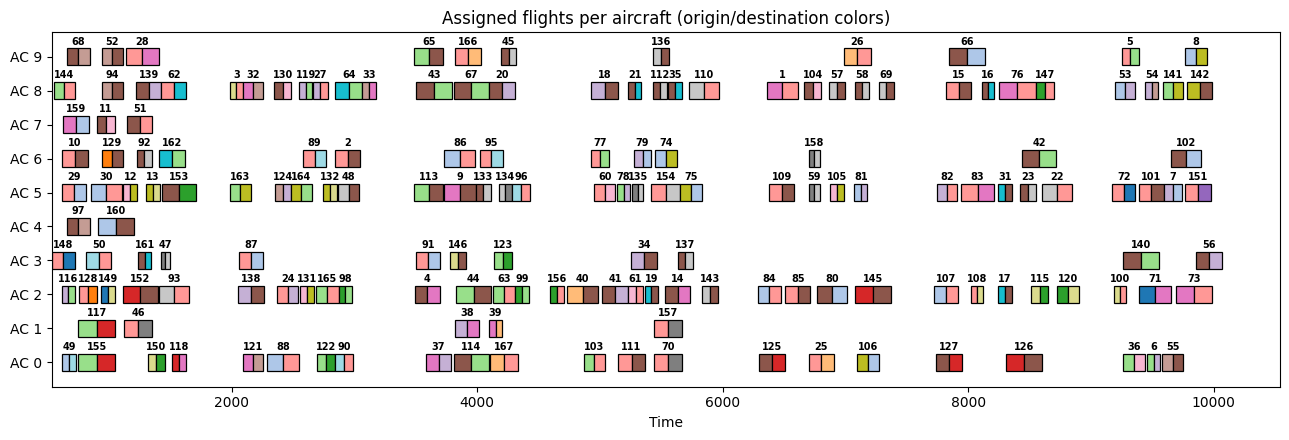

In [69]:
import matplotlib.pyplot as plt

# --------- Build assigned flights (now keep origin/dest) ----------
assigned = {a: [] for a in range(len(Aircrafts))}
airports = set()

for i in range(Nbflight):
    for a in range(len(Aircrafts)):
        if x[i, a].X > 0.5:
            dep = float(Flight[i][3])
            arr = float(Flight[i][4])
            fid = Flight[i][0]
            origin = Flight[i][1]
            dest   = Flight[i][2]
            assigned[a].append((dep, arr, fid, origin, dest))
            airports.add(origin)
            airports.add(dest)

# sort flights per aircraft by departure time
for a in range(len(Aircrafts)):
    assigned[a].sort(key=lambda t: t[0])

# --------- Assign one color per airport ----------
airports = sorted(list(airports))
cmap = plt.get_cmap("tab20", len(airports))
airport_color = {ap: cmap(idx) for idx, ap in enumerate(airports)}

# --------- Plot ----------
row_spacing = 1.4   # increase spacing between aircraft rows
bar_height  = 0.7   # slightly taller bars

fig, ax = plt.subplots(figsize=(13, 0.45 * max(1, len(Aircrafts))))

y = 0
yticks = []
ylabels = []

for a in range(len(Aircrafts)):
    if not assigned[a]:
        continue

    yticks.append(y)
    ylabels.append(f"AC {Aircrafts[a]}")

    for (dep, arr, fid, origin, dest) in assigned[a]:
        duration = arr - dep
        mid = dep + duration / 2.0

        # left half = origin color
        ax.barh(
            y, mid - dep, left=dep, height=bar_height,
            color=airport_color[origin],
            edgecolor="black", linewidth=0.9
        )

        # right half = destination color
        ax.barh(
            y, arr - mid, left=mid, height=bar_height,
            color=airport_color[dest],
            edgecolor="black", linewidth=0.9
        )

        # flight ID ABOVE the block (centered)
        ax.text(
            dep + duration/2,
            y + bar_height/2 + 0.08,
            str(fid),
            ha="center",
            va="bottom",
            fontsize=7,
            fontweight="bold"
        )

    y += row_spacing

ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_xlabel("Time")
ax.set_title("Assigned flights per aircraft (origin/destination colors)")
plt.tight_layout()
plt.show()